####Workspace to extract features from a spectrograph using a CNN

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO) #This way we can see the training information

In [0]:
#Load entire dataset into XY
#XY should have following properties
# object type = numpy.ndarray
# dimensions = (samples, 1 + 40 x 183 = 7320) = (M,N)
#e.g.
#XY = np.array(
#    [1, pixel 1, pixel 2, ... , pixel 7320], #spectrograph 1
#    [0, pixel 1, pixel 2, ... , pixel 7320], #spectrograph 2
#    [1, pixel 1, pixel 2, ... , pixel 7320], #spectrograph 3
#    .
#    .
#    .
#    [0, pixel 1, pixel 2, ... , pixel 7320], #spectrograph M-1
#    [1, pixel 1, pixel 2, ... , pixel 7320] #spectrograph M
#)
#Notice that input training data is a 2D vector with dim (#entries, #pixles each entry)

XY = np.random.randint(255, size=(300, 7320))
Y = np.random.choice((0,1),size=(300,1))
XY = np.hstack((Y,XY))
#np.random.shuffle(XY) #No need to shuffle, it will be done later
Y = np.asarray(XY[:,0],dtype=np.int32) #(M,)
X = np.asarray(XY[:,1:],dtype=np.float32) #(M,7320)

print(f' Type Y{type(Y)}\n Type X{type(X)}\n Type XY{type(XY)}')
print(f' Y shape {Y.shape}\n X shape {X.shape}')

 Type Y<class 'numpy.ndarray'>
 Type X<class 'numpy.ndarray'>
 Type XY<class 'numpy.ndarray'>
 Y shape (300,)
 X shape (300, 7320)


Notice that input training data is a 2D vector: (\#entries, \#pixles each entry)

For the model below, be familiar with arguments of: \
* https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
* https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d
* https://www.tensorflow.org/api_docs/python/tf/layers/dense

Understand Convolution Arguments: \
* http://machinelearninguru.com/computer_vision/basics/convolution/convolution_layer.html
* https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
* https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [0]:
def cnn_model_fn(features, labels, mode):
  """
  Custom model function for a CNN estimator object
  """
  
  #Input preprocessing layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # spectographs are 40x183 pixels, and have one color channel
  input_layer = tf.reshape(features["x"],[-1,40,183,1]) #-1 means adjust batch size so that feature data fills the dimension of (40,183,1) before the starting the next batch element
  
  #Module 1: Extraction
  # Computes 32 new features using a 7x11 filter with ReLU activation. Filter dimensions preserve ratios of convolution 7/40~5/28, 11/(183/3)~5/28
  # Padding is added to preserve width and height during convolution.
  # The (1,1) stride makes each new feature have same dimensions as input spectrograph
  # Input Tensor Shape: [batch_size, 40, 183, 1]
  # Output Tensor Shape: [batch_size, 40, 183, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[9,11], # Alec, I changed this variable from [7,11]
      strides=(1, 1),
      padding="same",
      activation=tf.nn.relu)
  # First max pooling layer with a 3x5 filter and stride of 2. Filter dimensions preserve ratios of shrinking filters 3/7~2/5, 5/11~2/5
  # The stride cuts the X's image dimensions by ceil(2)
  # Retains the newest 32 features
  # Input Tensor Shape: [batch_size, 40, 183, 32]
  # Output Tensor Shape: [batch_size, 20, 92, 32]
  pool1 = tf.layers.max_pooling2d(
      inputs=conv1,
      pool_size=[3,5],
      strides=(2,2),
      padding='same',
  )
  
  #Module 2: Extraction
  # Computes 32 new features, totaling 32+32=64 using a 7x11 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 20, 92, 32]
  # Output Tensor Shape: [batch_size, 20, 92, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[7,11],
      strides=(1, 1),
      padding="same",
      activation=tf.nn.relu
  )
  # Second max pooling layer with a 3x5 filter and stride of 2
  # The stride cuts the X's image dimensions by ceil(2)
  # Retains the total 64 features
  # Input Tensor Shape: [batch_size, 20, 92, 64]
  # Output Tensor Shape: [batch_size, 10, 46, 64]
  pool2 = tf.layers.max_pooling2d(
      inputs=conv2,
      pool_size=[3,5],
      strides=(2,2),
      padding='same'
  )
  
  #Module 3: Prediction
  # Flatten tensor into a batch of vectors, just like our input
  # Input Tensor Shape: [batch_size, 10, 46, 64]
  # Output Tensor Shape: [batch_size, 10 * 46 * 64 = 29,440]
  pool2_flattened = tf.reshape(
      pool2,
      [-1, 10 * 46 * 64]
  )
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 10 * 46 * 64 = 29,440]
  # Output Tensor Shape: [batch_size, 4096 = 2^12]
  dense = tf.layers.dense(
      inputs=pool2_flattened,
      units=4096,
      activation=tf.nn.relu)
  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense,
      rate=0.4,
      training= (mode==tf.estimator.ModeKeys.TRAIN) )
  # Input Tensor Shape: [batch_size, 4096 = 2^12]
  # Output Tensor Shape: [batch_size, 2 = 2^1]
  logits = tf.layers.dense(inputs=dropout, units=2)
  
  #Modes
  #Based on the mode, return a different value
  #Modes include: Train, Test, Predict, Eval
  
  #  Predict Mode
  predictions = {
      #Generate the logits predictions as a dictionary
      #  One key for the flattened convolution features of each input image
      "features_flat": pool2_flattened,
      #  One key for the dense features of each input image
      "features_dense": dense,
      #  One key for the predicted classes from logits
      "classes": tf.argmax(input=logits,axis=1),
      #  One key of the overal logits vector shape
      "probabilities": tf.nn.softmax(logits,name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
  
  #  Train & Eval Mode
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
  #  Train
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step()
    )
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op
    )
  
  #  Eval
  eval_metric_ops = {
      #Generate the evaluation metrics as a dictionary
      "accuracy": tf.metrics.accuracy(
          labels=labels,
          predictions=predictions["classes"]
      )
  }
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      eval_metric_ops=eval_metric_ops
  )

In [0]:
#log appropriately
#https://stackoverflow.com/questions/46013115/how-to-change-global-step-in-tensorflows-skcompat
  config = tf.estimator.RunConfig(
    save_summary_steps=4,
    log_step_count_steps=4 #this is where we display log outputs. should be a factor of training "steps" below
  )

  #create correct estimator using the custom "cnn_model_fn" defined above
  mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn,
    model_dir="/tmp/tf_cnn_spectograph_model",
    config=config
  )
  
  #log progress while training
  tensors_to_log = {"probabilities": "softmax_tensor"}
  logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log,
    every_n_iter=25 #Only affect the long log output. Does not affect how frequently we see "steps" in output. If not divisible by number of steps, it will take precedence. IE log_iter=5, #steps=11 -> Training will last for 16steps
  )

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_cnn_spectograph_model', '_tf_random_seed': None, '_save_summary_steps': 4, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 4, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd691745198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
#prepare training input with shuffling, batching, etc
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X},
    y=Y,
    batch_size=50,
    num_epochs=None,
    shuffle=True
  )
  
  ##train the model by calling "estimator.train"
  mnist_classifier.train(
    input_fn=train_input_fn,
    steps=2, #Batch size = 50, total data = 300, so there are 6 steps in one epoch, we'll do 4 epochs or 32 steps over a total of 1,200 images
    hooks=None #[logging_hook]
  )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_cnn_spectograph_model/model.ckpt-35
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 35 into /tmp/tf_cnn_spectograph_model/model.ckpt.
INFO:tensorflow:loss = 0.6918565, step = 36
INFO:tensorflow:Saving checkpoints for 37 into /tmp/tf_cnn_spectograph_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.69315773.


[0 0 1 0 0 1 1 1 0 0 0 1 0 0 0]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_cnn_spectograph_model/model.ckpt-37
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'features_flat': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'features_dense': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'classes': 0, 'probabilities': array([0.50240076, 0.49759924], dtype=float32)}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_cnn_spectograph_model/model.ckpt-37
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


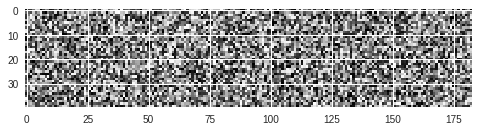

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


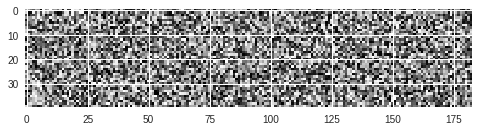

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


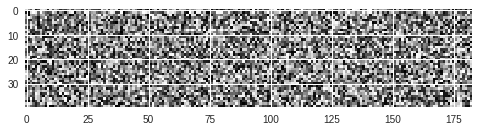

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


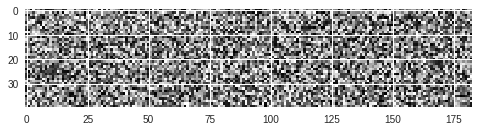

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


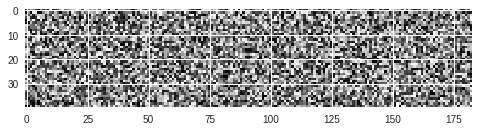

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


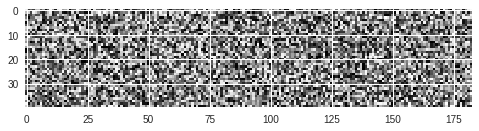

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


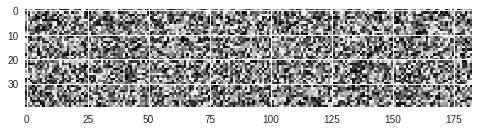

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


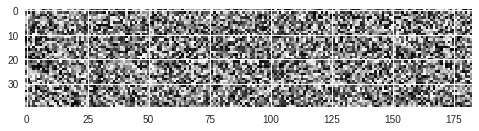

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


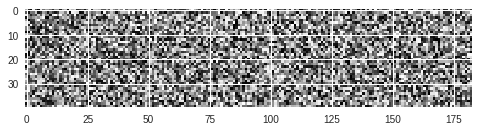

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


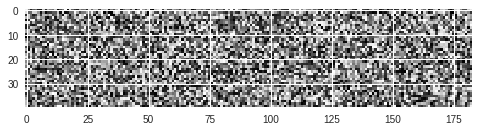

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


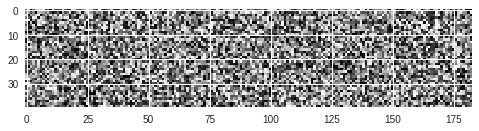

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


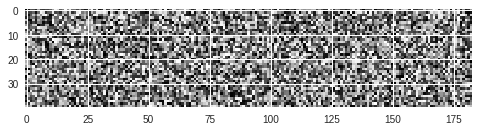

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


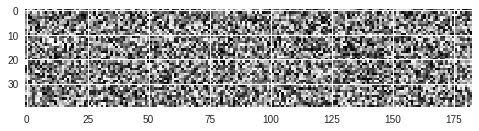

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


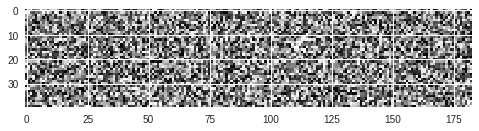

0 [0. 0. 0. 0. 0.]
0 [0. 0. 0. 0. 0.]


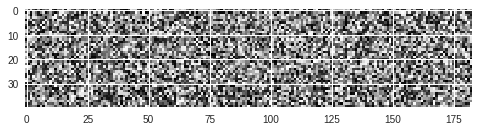

In [0]:
import matplotlib.pyplot as plt

#images = mnist.test.images[0:10]
images = X[0:300:20,:]
print(Y[0:300:20])
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x":images},
      num_epochs=1,
      shuffle=False)

a = mnist_classifier.predict(input_fn=predict_input_fn) #Creates something called a generator or iterator object in python. The only way to access its output is by iterating through with "next()" or a "for" loop
print(next(a))
#print(next(predictions)['features_flat'].shape)
#print(next(predictions)['features_dense'].shape)
for image_iter,prediction_iter in zip(images,mnist_classifier.predict(input_fn=predict_input_fn)):
    ffs = prediction_iter['features_flat'].size
    ffd = prediction_iter['features_dense'].size
    print(prediction_iter['classes'],prediction_iter['features_flat'][slice(0, -1, ffs//5),]) #Print the prediction
    print(prediction_iter['classes'],prediction_iter['features_dense'][slice(0, -1, ffd//5),]) #Print the prediction
    plt.imshow(image_iter.reshape(40, 183), cmap=plt.cm.binary) #Print the original image we are predicting
    plt.show() #Show the plot

###Alec's Notes to self:
Epoch = training on full dataset \
Batch = subset of full dataset, we feed these through in sequence to save memory \
Step = an alternative to epoch's, steps define the precise numbers of batches to train
* https://stackoverflow.com/questions/38340311/what-is-the-difference-between-steps-and-epochs-in-tensorflow
* https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

Convert Tensor to Numpy Array = if not automatic, use .eval() \
* https://stackoverflow.com/questions/34097281/how-can-i-convert-a-tensor-into-a-numpy-array-in-tensorflow

Predict = create estimator input structure, call estimator.predict, pass it the input \
* https://stackoverflow.com/questions/33711556/making-predictions-with-a-tensorflow-model

Generator object = the TensorFlow estimator.predict creates an iterator/generator object like a linked list. The only way to access its elements is to iterate through with "next()" or use a "for" loop \
* https://stackoverflow.com/questions/47911104/how-to-make-predictions-with-tf-estimator-estimator-from-checkpoint

Sessions = the way to write TensorFlow models at a lower level without the estimator wrapper \
* https://www.oreilly.com/ideas/building-deep-learning-neural-networks-using-tensorflow-layers

